# <b>Final Project - A Data Mining Approach to Air Pollution Analysis and Sustainable Policy Development </b>
### <i><font color="SlateGray">Authors: Vaibhav Rungta, Akash Vishwakarma, Himanshu Borole, Shantanu Jhaveri</font> </i>

<img src="k3FAST.gif" width="700"> 
<img src="K4FAST.gif" width="700">

## Section 1. Packages

In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import numpy as np 
os.listdir()

['Untitled1.ipynb',
 '.DS_Store',
 'combined_newData',
 'newData',
 'combined_data_with_clusters.csv',
 'ne_110m_land',
 'Untitled.ipynb',
 'code.ipynb',
 'notebook.ipynb',
 'vaibhavcode.ipynb',
 'histograms_grid.png',
 'code(1).ipynb',
 'combined_masked.csv',
 'processed_final.csv',
 'masked_clean.csv',
 'masked.csv',
 '.ipynb_checkpoints',
 'combined_masked_dropped.csv',
 'landmask',
 'logbook.ipynb']

## Section 2 : Preprocessing
###  2.1: Dataset Compilation

Merging emissions data across all years and aggregate the values using both the mean and standard deviation.

In [ ]:
# Define the root path for your data and the new directory for combined files
path_root = 'newData'
new_dir = 'combined_newData'
os.makedirs(new_dir, exist_ok=True)


# Function to categorize years into decades
def get_decade(year):
    return (year // 10) * 10

# Get the list of gases, excluding hidden files/folders
gases = [gas for gas in os.listdir(path_root) if not gas.startswith('.')]

for gas in gases:
    # Initialize a list to store dataframes
    dfs = []
    gas_path = os.path.join(path_root, gas)

    # Construct the path to the gas folder and list all text files
    txt_files = [os.path.join(gas_path, file) for file in os.listdir(gas_path) if file.endswith('.txt')]

    # Parse each text file and append the dataframe to the list
    for file in txt_files:
        dfs.append(parse_total_emissions_file_pandas(file))

    # Concatenate all dataframes for the current gas
    master_df = pd.concat(dfs, ignore_index=True)

    # Convert year to integer and categorize into decades
    master_df['year'] = master_df['year'].astype(int)
    master_df['decade'] = master_df['year'].apply(get_decade)

    # Group by the necessary columns and calculate mean and standard deviation
    aggregated_df = master_df.groupby(['lat', 'lon', 'gas', 'decade'])['emission'].agg(['mean', 'std']).reset_index()

    # Save the aggregated dataframe to a CSV file
    aggregated_csv_path = os.path.join(new_dir, f"{gas.replace('/', '_')}_aggregated.csv")
    aggregated_df.to_csv(aggregated_csv_path, index=False)

In [35]:
files = os.listdir('combined_newData')
os.listdir('combined_newData')

['PM2.5_aggregated.csv',
 '.DS_Store',
 'NH3_aggregated.csv',
 'OC_aggregated.csv',
 'PM10_aggregated.csv',
 'NOx_aggregated.csv',
 'SO2_aggregated.csv',
 'CO_aggregated.csv',
 'BC_aggregated.csv',
 'NMVOC_aggregated.csv']

In [ ]:
#now combining all individually aggregated files into one single dataset
import pandas as pd
import os

path = "combined_newData/"
files = os.listdir(path)

# Initialize an empty DataFrame for the final combined data
combined_df = None

for x in files:
    if x != ".DS_Store" and x.endswith(".csv"):
        gas_type = x[0:x.find('_')]
        filepath = os.path.join(path, x)
        df = pd.read_csv(filepath)

        # Rename 'mean' and 'std' columns to include the gas type
        df.rename(columns={'mean': f'{gas_type}_mean', 'std': f'{gas_type}_std'}, inplace=True)

        # Merge with the combined DataFrame
        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on=['lat', 'lon', 'decade'], how='inner')

        print(gas_type)
        print(x)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv(os.path.join(path, "combined_data.csv"), index=False)


In [3]:
combined_df = pd.read_csv('combined_newData/combined_data.csv')

### 2.2: Dropping na values

In [20]:
#dropping na values after combination 
combined_df.dropna(inplace = True)

In [21]:
combined_df.head()

,lat,lon,decade,PM2.5_mean,PM2.5_std,NH3_mean,NH3_std,OC_mean,OC_std,PM10_mean,...,NOx_mean,NOx_std,SO2_mean,SO2_std,CO_mean,CO_std,BC_mean,BC_std,NMVOC_mean,NMVOC_std
15,-89.8,-161.8,2010,0.000326,0.000201,2.965265e-07,1.827058e-07,0.000033,0.000020,0.000326,...,0.002883,0.001106,0.000326,0.000201,0.000176,0.000109,0.000065,0.000040,0.000127,0.000078
22,-89.7,-161.8,2010,0.000835,0.001054,7.654472e-07,9.674391e-07,0.000083,0.000105,0.000835,...,0.007087,0.008578,0.000835,0.001054,0.000455,0.000575,0.000167,0.000211,0.000328,0.000415
34,-89.6,-161.8,2010,0.001368,0.001617,1.258667e-06,1.491080e-06,0.000137,0.000162,0.001368,...,0.011984,0.013320,0.001368,0.001617,0.000748,0.000887,0.000274,0.000323,0.000540,0.000639
48,-89.5,-161.8,2010,0.000966,0.000782,8.856900e-07,7.212631e-07,0.000097,0.000078,0.000966,...,0.008739,0.005687,0.000966,0.000782,0.000526,0.000430,0.000193,0.000156,0.000380,0.000308
55,-89.4,-161.8,2010,0.000734,0.000737,6.728345e-07,6.782505e-07,0.000073,0.000074,0.000734,...,0.006472,0.005721,0.000734,0.000737,0.000400,0.000404,0.000147,0.000147,0.000289,0.000290


### 2.3: Application of Land Mask


In this section, a GeoDataFrame (`gdf`) is created from the `combined_df` by incorporating longitude and latitude information. Subsequently, a land mask is loaded from the 'ne_110m_land' shapefile. A spatial join operation is performed, resulting in a new GeoDataFrame (`gdf_on_land`) that intersects with the land mask.



In [22]:
#reading in as a geopandas dataframe for landmask application 
gdf = gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df.lon, combined_df.lat))

In [15]:
# Load the land mask
land_mask = gpd.read_file('ne_110m_land/ne_110m_land.shp')

In [ ]:
# Perform spatial join
gdf_on_land = gpd.sjoin(gdf, land_mask, how="inner", op='intersects')

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

# Assuming land_mask is your GeoDataFrame of the land mask
# Extract coastlines (boundaries of the land polygons)
coastlines = land_mask.boundary

# Create a Cartopy subplot to handle projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the custom coastlines
for line in coastlines:
    if line.geom_type == 'LineString':
        x, y = line.xy
        ax.plot(x, y, color='black', linewidth=1, transform=ccrs.Geodetic())
    elif line.geom_type == 'MultiLineString':
        for part in line.geoms:
            x, y = part.xy
            ax.plot(x, y, color='black', linewidth=1, transform=ccrs.Geodetic())

# Plot the points from the GeoDataFrame
lon, lat = gdf_on_land.geometry.x, gdf_on_land.geometry.y
ax.scatter(lon, lat, s=5, color='blue', transform=ccrs.Geodetic())

plt.title('Dataset After Applying Land Mask with Custom Coastlines')
plt.show()

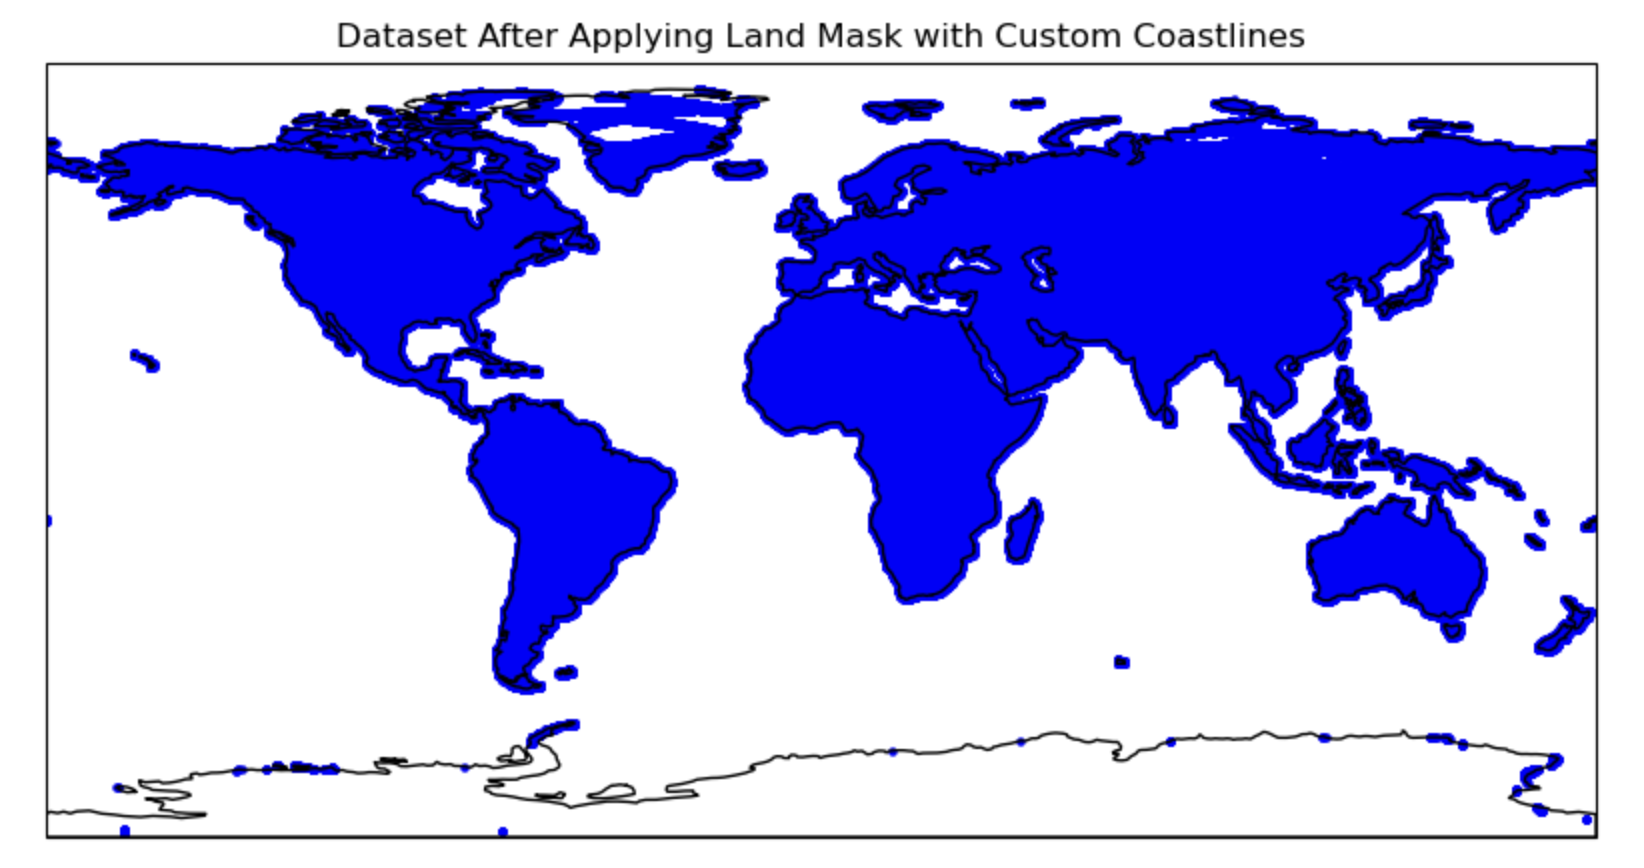

In [26]:
gdf_on_land.to_csv('combined_masked_unprocessed.csv')

In [30]:
gdf_on_land.head()

,lat,lon,decade,PM2.5_mean,PM2.5_std,NH3_mean,NH3_std,OC_mean,OC_std,PM10_mean,...,CO_std,BC_mean,BC_std,NMVOC_mean,NMVOC_std,geometry,index_right,featurecla,scalerank,min_zoom
15,-89.8,-161.8,2010,0.000326,0.000201,2.965265e-07,1.827058e-07,0.000033,0.000020,0.000326,...,0.000109,0.000065,0.000040,0.000127,0.000078,POINT (-161.80000 -89.80000),7,Land,0,0.0
22,-89.7,-161.8,2010,0.000835,0.001054,7.654472e-07,9.674391e-07,0.000083,0.000105,0.000835,...,0.000575,0.000167,0.000211,0.000328,0.000415,POINT (-161.80000 -89.70000),7,Land,0,0.0
34,-89.6,-161.8,2010,0.001368,0.001617,1.258667e-06,1.491080e-06,0.000137,0.000162,0.001368,...,0.000887,0.000274,0.000323,0.000540,0.000639,POINT (-161.80000 -89.60000),7,Land,0,0.0
48,-89.5,-161.8,2010,0.000966,0.000782,8.856900e-07,7.212631e-07,0.000097,0.000078,0.000966,...,0.000430,0.000193,0.000156,0.000380,0.000308,POINT (-161.80000 -89.50000),7,Land,0,0.0
55,-89.4,-161.8,2010,0.000734,0.000737,6.728345e-07,6.782505e-07,0.000073,0.000074,0.000734,...,0.000404,0.000147,0.000147,0.000289,0.000290,POINT (-161.80000 -89.40000),7,Land,0,0.0


In [32]:
gdf_on_land.drop(columns = ['geometry', 'index_right', 'featurecla', 'scalerank', 'min_zoom'], inplace = True)

In [33]:
gdf_on_land.head()

,lat,lon,decade,PM2.5_mean,PM2.5_std,NH3_mean,NH3_std,OC_mean,OC_std,PM10_mean,...,NOx_mean,NOx_std,SO2_mean,SO2_std,CO_mean,CO_std,BC_mean,BC_std,NMVOC_mean,NMVOC_std
15,-89.8,-161.8,2010,0.000326,0.000201,2.965265e-07,1.827058e-07,0.000033,0.000020,0.000326,...,0.002883,0.001106,0.000326,0.000201,0.000176,0.000109,0.000065,0.000040,0.000127,0.000078
22,-89.7,-161.8,2010,0.000835,0.001054,7.654472e-07,9.674391e-07,0.000083,0.000105,0.000835,...,0.007087,0.008578,0.000835,0.001054,0.000455,0.000575,0.000167,0.000211,0.000328,0.000415
34,-89.6,-161.8,2010,0.001368,0.001617,1.258667e-06,1.491080e-06,0.000137,0.000162,0.001368,...,0.011984,0.013320,0.001368,0.001617,0.000748,0.000887,0.000274,0.000323,0.000540,0.000639
48,-89.5,-161.8,2010,0.000966,0.000782,8.856900e-07,7.212631e-07,0.000097,0.000078,0.000966,...,0.008739,0.005687,0.000966,0.000782,0.000526,0.000430,0.000193,0.000156,0.000380,0.000308
55,-89.4,-161.8,2010,0.000734,0.000737,6.728345e-07,6.782505e-07,0.000073,0.000074,0.000734,...,0.006472,0.005721,0.000734,0.000737,0.000400,0.000404,0.000147,0.000147,0.000289,0.000290


### 2.4: Log Transformation and Standardization

In this section, a Python script is employed to apply a log transformation and z-score standardization to selected columns in the GeoDataFrame (`gdf_on_land`). The `log_transform_and_standardize_column` function is defined for this purpose. Columns such as 'lat', 'lon', and 'decade' are excluded from the processing.

In [34]:
import numpy as np
from scipy.stats import zscore

def log_transform_and_standardize_column(column):
    # Apply log transformation
    transformed_column = np.log(column + 1e-9)

    # Apply z-score standardization
    standardized_column = zscore(transformed_column)

    return standardized_column
    
columns_to_skip = ['lat', 'lon', 'decade']

for col in gdf_on_land.columns:
    if col not in columns_to_skip:
        gdf_on_land[col] = log_transform_and_standardize_column(gdf_on_land[col])
        print(col+"processed")

PM2.5_meanprocessed
PM2.5_stdprocessed
NH3_meanprocessed
NH3_stdprocessed
OC_meanprocessed
OC_stdprocessed
PM10_meanprocessed
PM10_stdprocessed
NOx_meanprocessed
NOx_stdprocessed
SO2_meanprocessed
SO2_stdprocessed
CO_meanprocessed
CO_stdprocessed
BC_meanprocessed
BC_stdprocessed
NMVOC_meanprocessed
NMVOC_stdprocessed


In [36]:
gdf_on_land.to_csv('combined_masked_processed.csv')

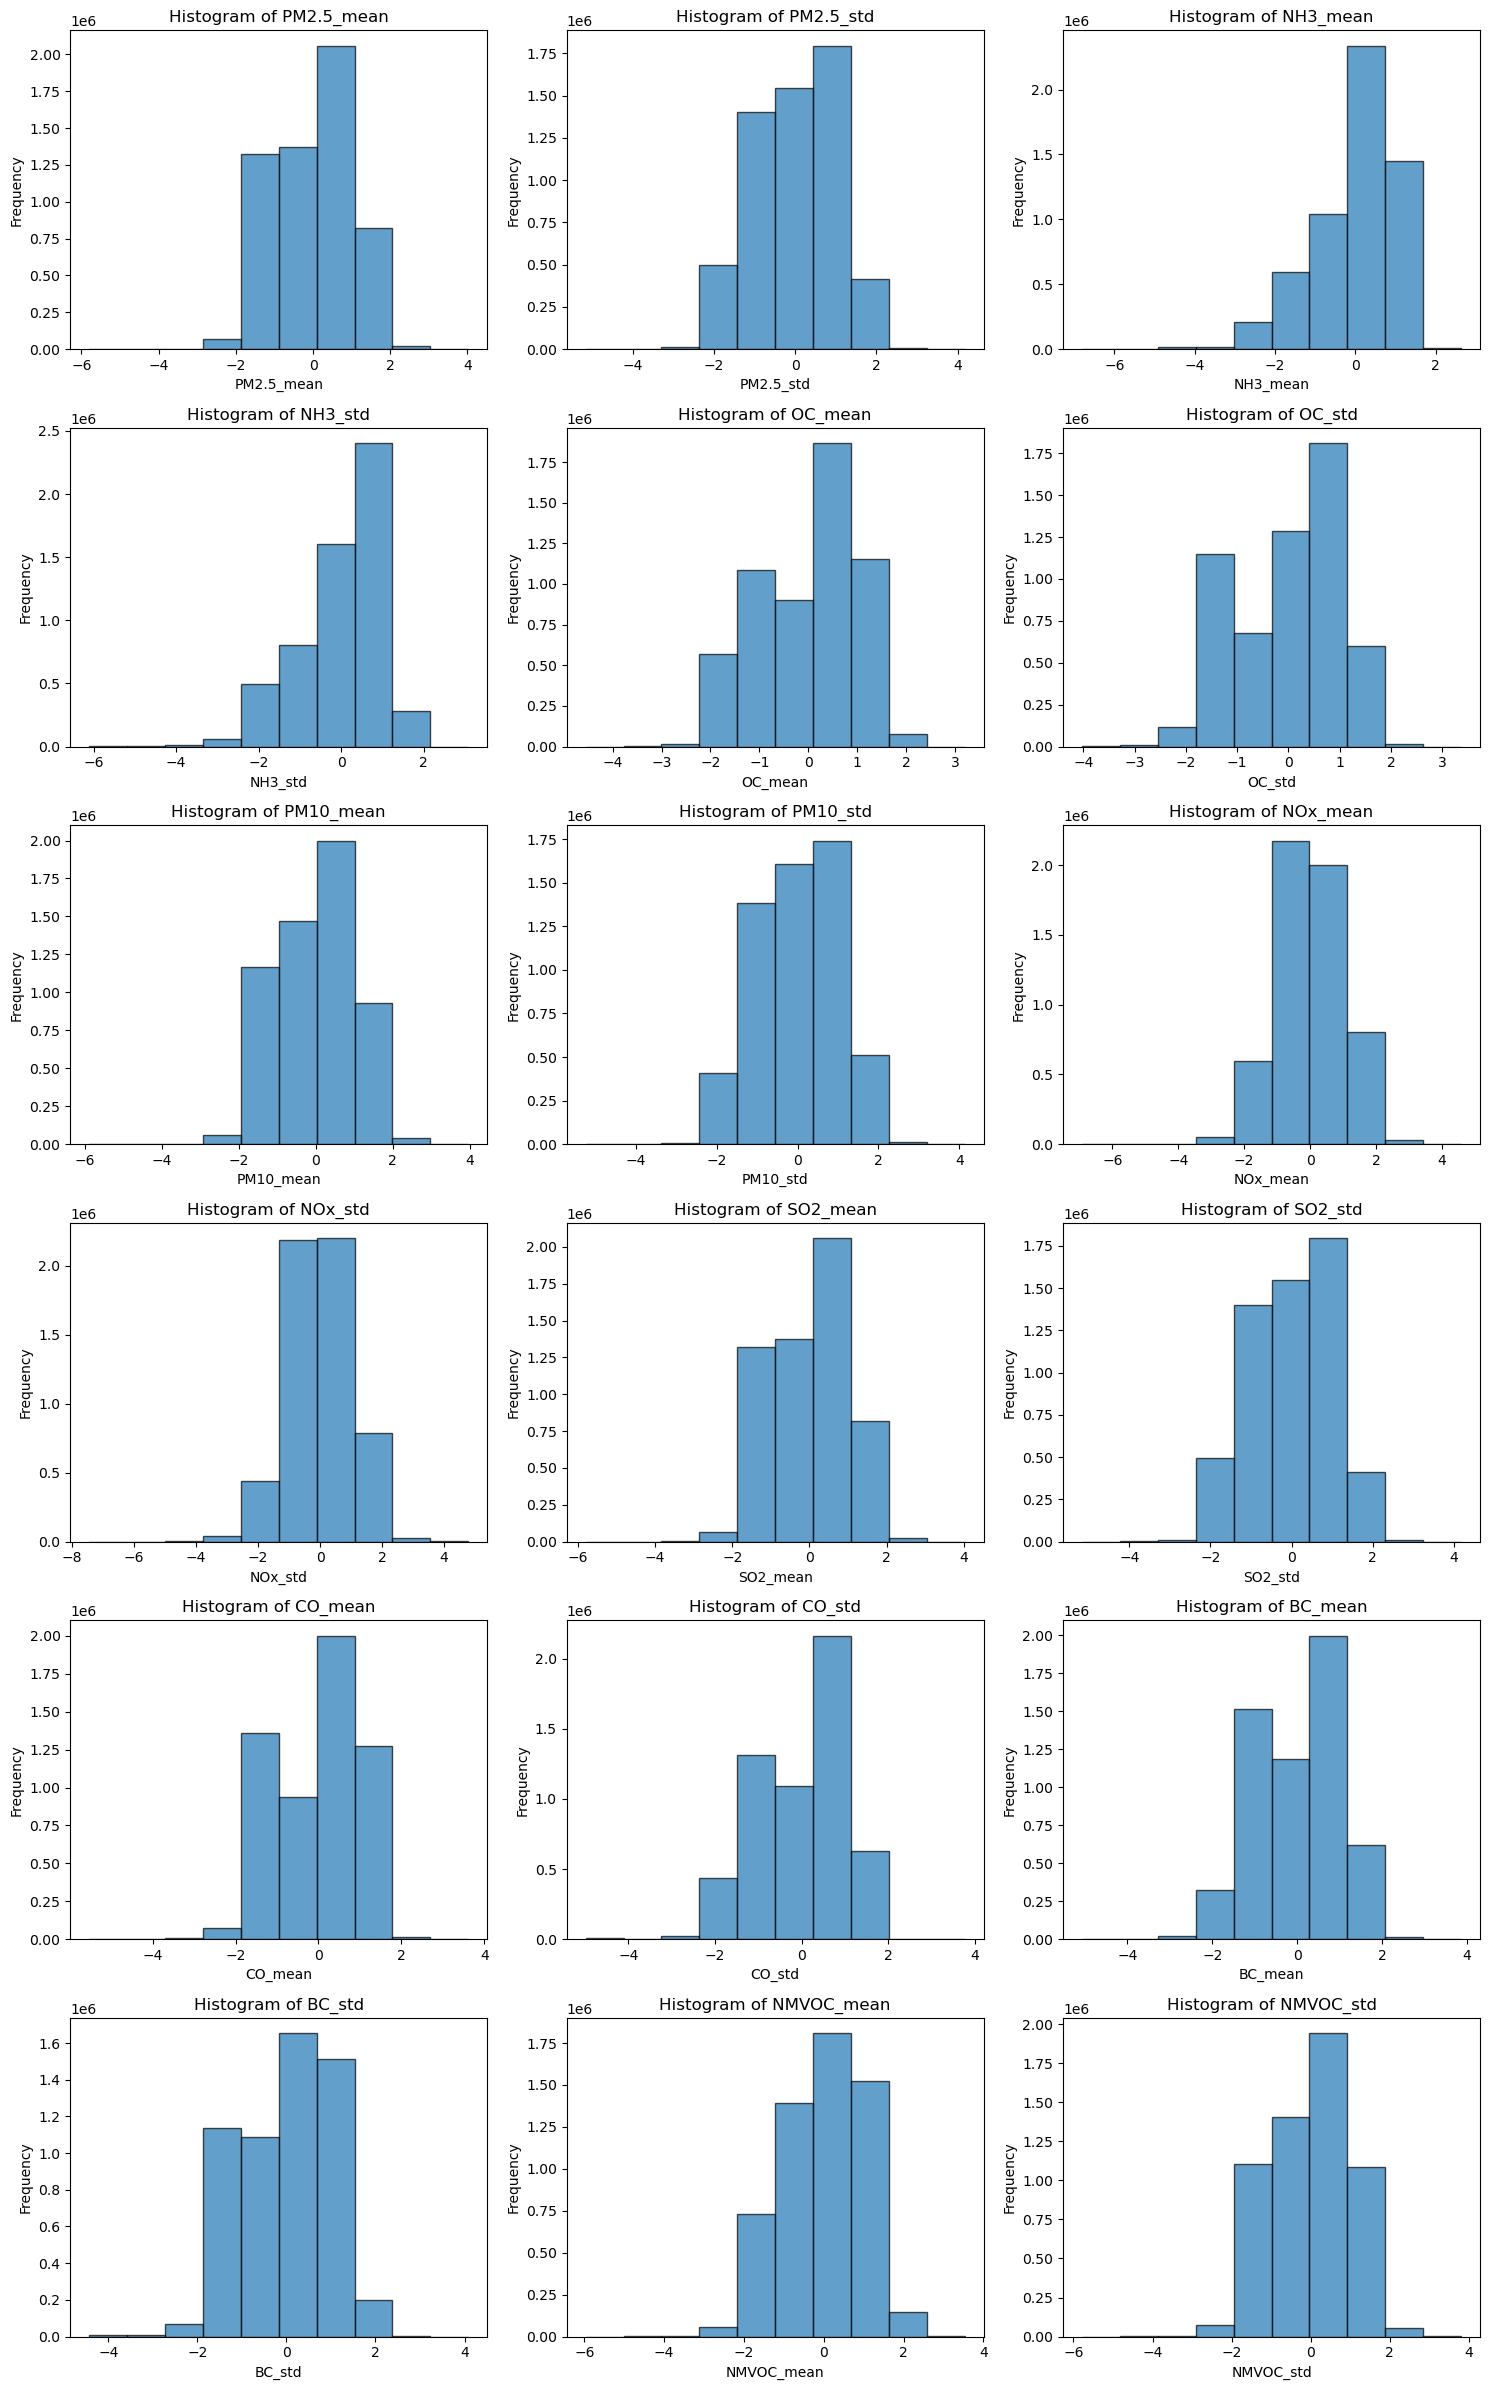

In [37]:
import matplotlib.pyplot as plt

# Columns to exclude from the histogram plots
exclude_cols = ['lat', 'lon', 'decade']

# Filter out columns to exclude
filtered_columns = [col for col in gdf_on_land.columns if col not in exclude_cols]

# Determine the layout of the subplot grid
num_cols = 3  # Number of columns in the grid
num_rows = (len(filtered_columns) + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the filtered columns and create a histogram for each
for i, col in enumerate(filtered_columns):
    axes[i].hist(gdf_on_land[col], bins=10, edgecolor='k', alpha=0.7)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.savefig('histograms_grid.png', dpi=300)  # Adjust filename and dpi as needed
plt.show()


In [2]:
gdf_on_land.shape

(5669893, 22)

## Section 3: Clustering
### 3.1 : Elbow Curve

In this section, an elbow curve and silhouette score analysis are conducted to identify the optimal number of clusters for the k-means clustering algorithm. These metrics provide insights into the appropriate value of k for partitioning the standardized and transformed dataset.

In [1]:
import pandas as pd 
gdf_on_land = pd.read_csv('combined_masked_processed.csv')

In [ ]:
import pandas as pd
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering, which excludes 'lat', 'lon', 'decade', and cluster label columns
feature_columns = [col for col in gdf_on_land.columns if col not in ['lat', 'lon', 'decade'] and 'k_cluster' not in col and '1' not in col]

# Range of k values to try
k_values = range(2, 15)

# Store sum of squared distances for each k
sum_of_squared_distances = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(gdf_on_land[feature_columns])
    sum_of_squared_distances.append(kmeans.inertia_)
    # Add the cluster labels to the DataFrame
    gdf_on_land[f'k_cluster_{k}'] = kmeans.labels_

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

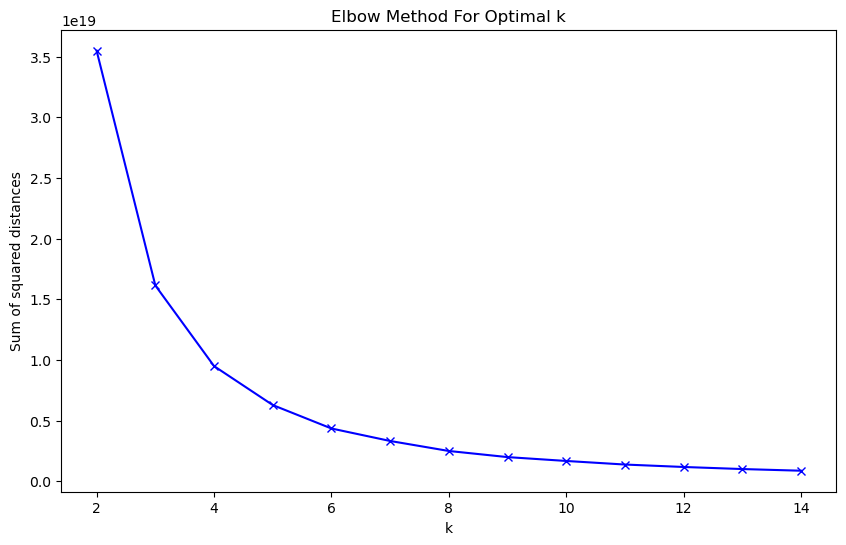

In [4]:
# Save the DataFrame with all cluster labels

gdf_on_land.to_csv('combined_masked_processed_clustered.csv')

### 3.2: Silhouette Score Analysis

In [19]:
gdf_on_land = pd.read_csv("combined_masked_processed_clustered.csv")

In [4]:
import pandas as pd
import os
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

gdf = pd.read_csv('combined_newData/combined_data_with_clusters.csv')

# Select features for clustering, which excludes 'lat', 'lon', 'decade', and cluster label columns
feature_columns = [col for col in gdf.columns if col not in ['lat', 'lon', 'decade'] and 'k_cluster' not in col and '1' not in col]




Starting...
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
calculating...
done
Finished...


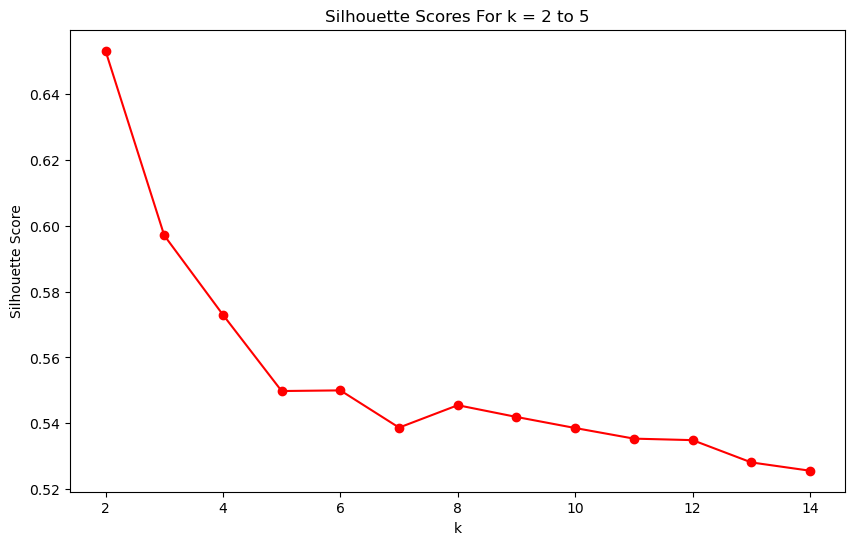

In [7]:
import pandas as pd
import os
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Sample a percentage of the dataset (e.g., 10%)
sample_fraction = 0.008
df_sampled = gdf_on_land.sample(frac=sample_fraction, random_state=42)

# Define the range of k values to consider
k_range = range(2, 15)  # From k=2 to k=5

# Store silhouette scores for each k within the specified range
silhouette_scores = {}
print("Starting...")
for k in k_range:
    k_cluster_col = f'k_cluster_{k}'

    labels = df_sampled[k_cluster_col]
    # Check if there are at least two unique clusters
    print("calculating...")
    score = silhouette_score(df_sampled[feature_columns], labels)
    silhouette_scores[k] = score
    print("done")
print("Finished...")

# Sorting the scores for better plotting
sorted_scores = sorted(silhouette_scores.items())

# Plotting the silhouette scores
k_values, scores = zip(*sorted_scores)
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For k = 2 to 5')
plt.show()